In [6]:
import math
import numpy as np
import bisect


class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position

        if t is outside of the input x, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative

        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class

    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s



In [7]:
import csv

sample_time = 0.01

waypoints_file = "racetrack_waypoints.txt"
waypoints_np   = None
with open(waypoints_file) as waypoints_file_handle:
    waypoints = list(csv.reader(waypoints_file_handle, 
                                delimiter=',',
                                quoting=csv.QUOTE_NONNUMERIC))
    waypoints_np = np.array(waypoints)
waypoints_t = np.transpose(waypoints_np)

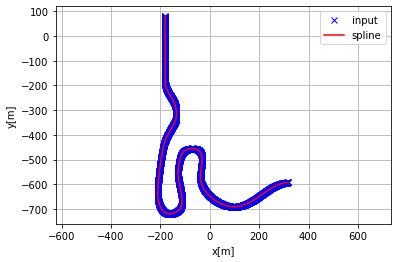

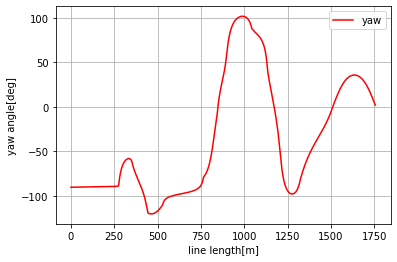

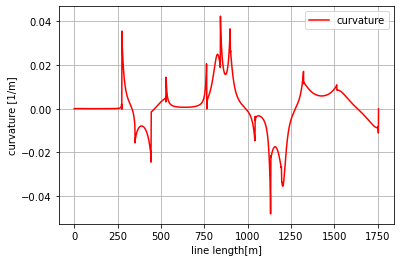

In [8]:
import matplotlib.pyplot as plt
x = waypoints_t[0]
y = waypoints_t[1]
ds = 0.01  # [m] distance of each intepolated points

sp = Spline2D(x, y)
s = np.arange(0, sp.s[-1], ds)

rx, ry, ryaw, rk = [], [], [], []
for i_s in s:
    ix, iy = sp.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    ryaw.append(sp.calc_yaw(i_s))
    rk.append(sp.calc_curvature(i_s))

plt.subplots(1)
plt.plot(x, y, "xb", label="input")
plt.plot(rx, ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()

plt.subplots(1)
plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("yaw angle[deg]")

plt.subplots(1)
plt.plot(s, rk, "-r", label="curvature")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("curvature [1/m]")

plt.show()

